In [1]:
import cv2
#from utils import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K

In [5]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import pandas as pd

In [111]:
def load(test=False):
    FTRAIN = 'training/training.csv'
    FTEST = 'test/test.csv'
    
    filename = FTEST if test else FTRAIN

    df = read_csv(os.path.expanduser(filename))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    cols = df.columns
    
    X = np.vstack(df['Image'].values)/255.

    if (test==False):
        y = df[df.columns[0:30]].values
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
    else:
        y = None
        cols = None

    X = X.astype(np.float32)
    
    return X, y, cols

def load_2D(test=False):
    X, y, cols = load(test)
    X = X.reshape(-1, 96, 96, 1)
    
    return X, y, cols

In [112]:
# Load training data
X_train, y_train, label_cols = load_2D(test=False)


In [113]:
print("Train data shape: ", X_train.shape, " and Train label shape: ", y_train.shape)
print("Labels: ", label_cols[:-1])

Train data shape:  (2140, 96, 96, 1)  and Train label shape:  (2140, 30)
Labels:  Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


In [114]:
# Load training data
X_test, y_test, label_cols = load_2D(test=True)


In [115]:
print("Test data shape: ", X_test.shape, " and Test label shape: ", y_test)
print("Labels: ", label_cols)

Test data shape:  (1783, 96, 96, 1)  and Test label shape:  None
Labels:  None


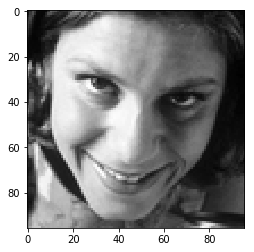

In [116]:
plt.imshow(X_train[1].reshape(96,96), cmap='gray')

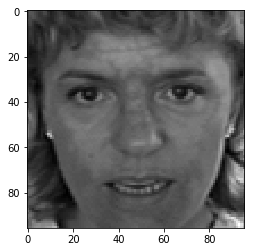

In [117]:
plt.imshow(X_test[1].reshape(96,96), cmap='gray')

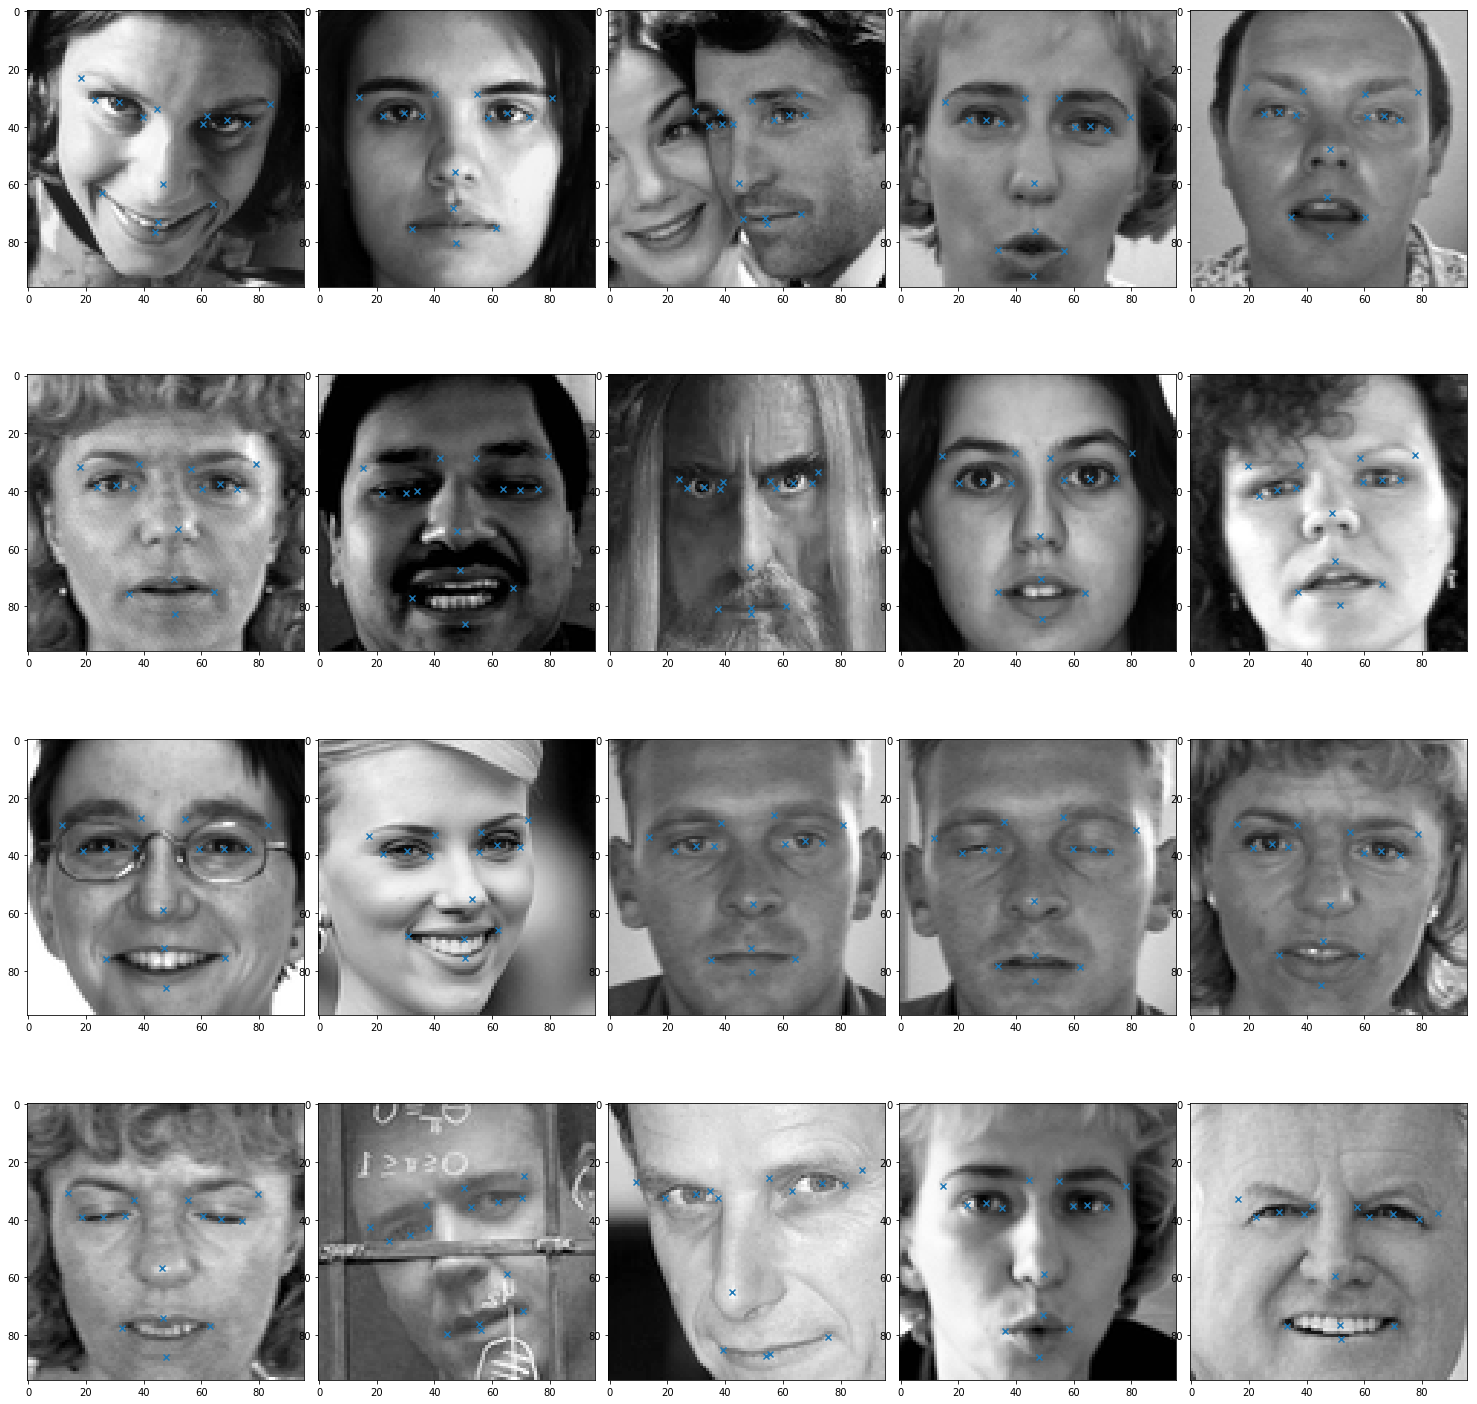

In [119]:
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i, :, :, 0].reshape(96,96), cmap='gray')
    plt.scatter(y_train[i, range(0,30,2)], y_train[i, range(1,30,2)], marker='x')
#    plt.scatter(y_train.values[i, range(0,30,2)], y_train.values[i, range(1,30,2)], marker='x')
#    ax = fig.add_subplot(3,3,i+1, xticks=[], yticks=[])
#    plot_img(X_train[i], y_train[i], ax)
    
#plt.tight_layout()
plt.show()


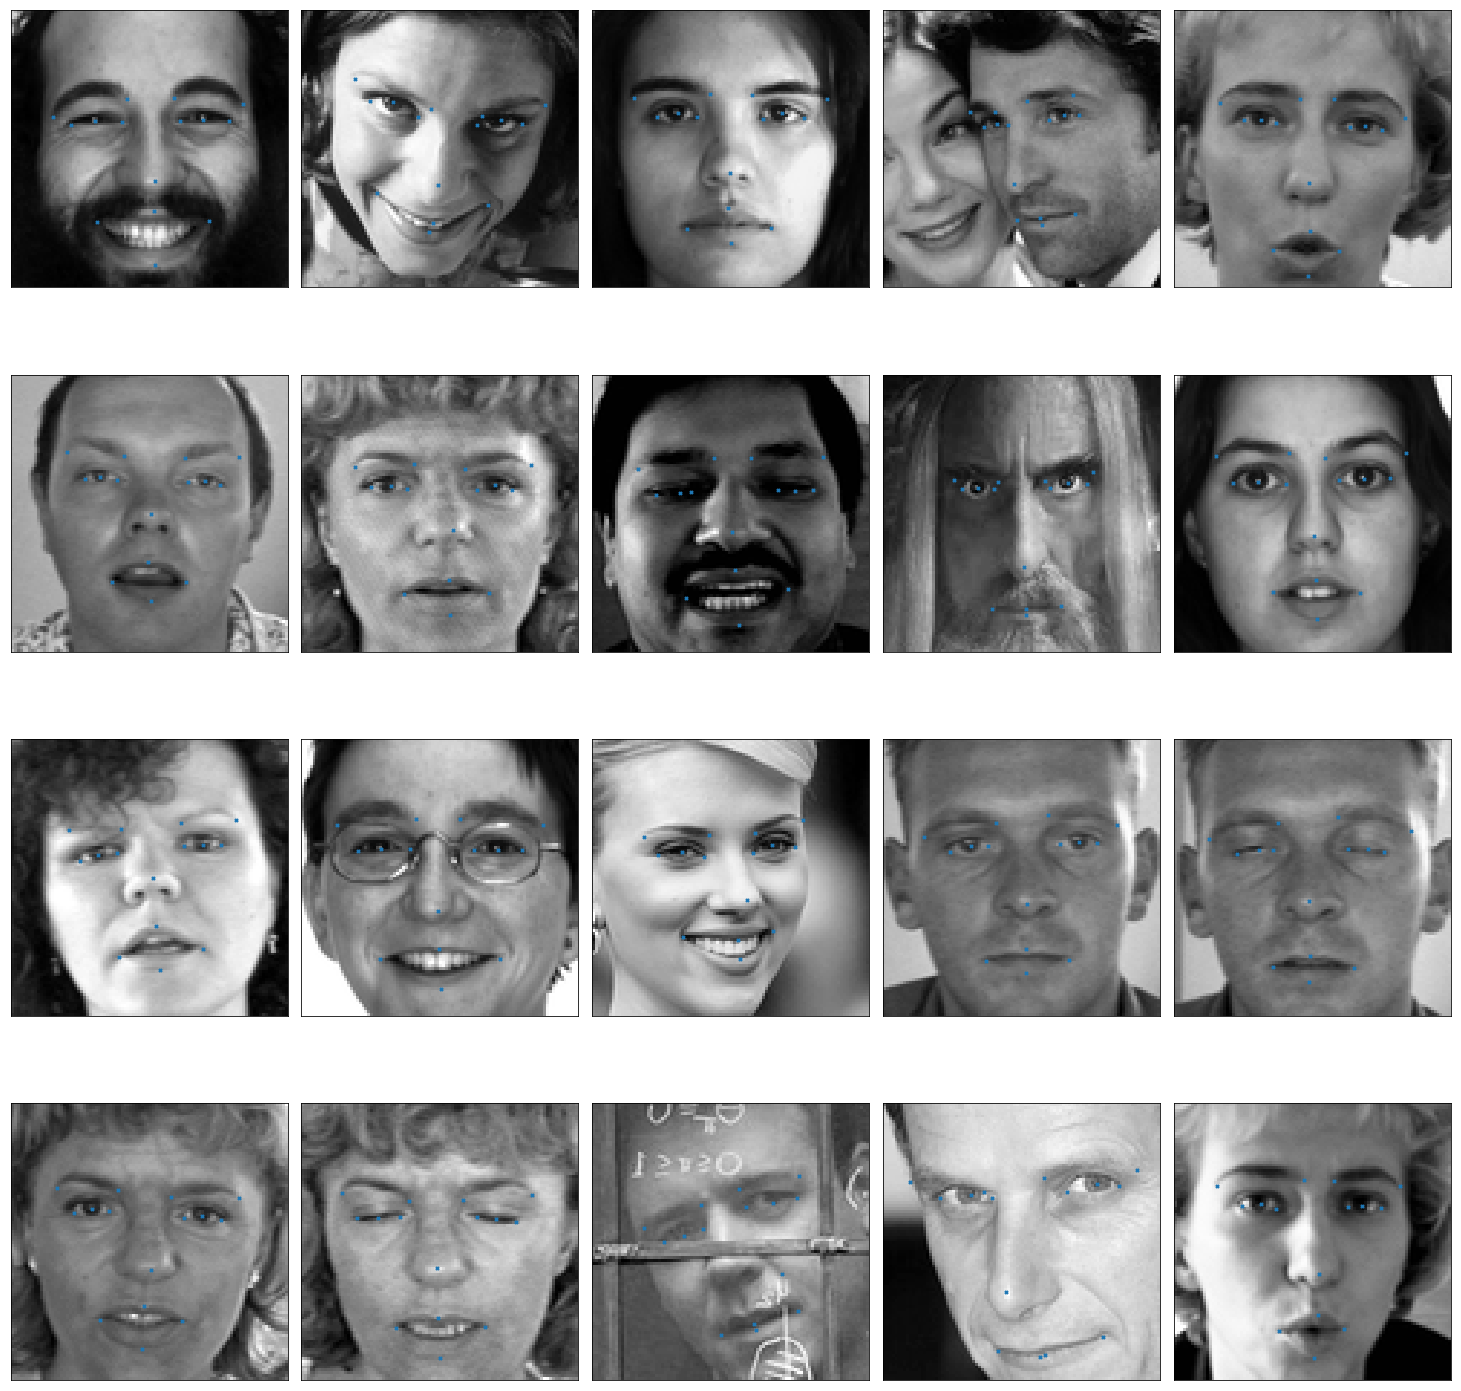

In [129]:
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_train[i], y_train[i], ax)
    
plt.show()

## Train Convolutional Neural Network

In [149]:
from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(300))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_67 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_68 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 23, 23, 48)        0         
__________

In [150]:
%time res = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/5
 - 24s - loss: 1240.2225 - rmse: 33.0678 - acc: 0.0041 - mean_absolute_error: 28.4387 - val_loss: 284.2493 - val_rmse: 16.8534 - val_acc: 0.2523 - val_mean_absolute_error: 12.8463
Epoch 2/5
 - 25s - loss: 164.8452 - rmse: 12.6341 - acc: 0.2675 - mean_absolute_error: 9.6263 - val_loss: 108.7297 - val_rmse: 10.4179 - val_acc: 0.6636 - val_mean_absolute_error: 8.2510
Epoch 3/5
 - 24s - loss: 84.2117 - rmse: 9.1257 - acc: 0.7033 - mean_absolute_error: 6.8478 - val_loss: 66.2968 - val_rmse: 8.1311 - val_acc: 0.6963 - val_mean_absolute_error: 6.0791
Epoch 4/5
 - 22s - loss: 57.8263 - rmse: 7.5730 - acc: 0.7068 - mean_absolute_error: 5.6786 - val_loss: 50.4954 - val_rmse: 7.0919 - val_acc: 0.6963 - val_mean_absolute_error: 5.2549
Epoch 5/5
 - 23s - loss: 41.3640 - rmse: 6.4167 - acc: 0.7074 - mean_absolute_error: 4.7726 - val_loss: 40.3075 - val_rmse: 6.3311 - val_acc: 0.6963 - val_mean_absolute_error: 4.7000
Wall time: 1min 58s


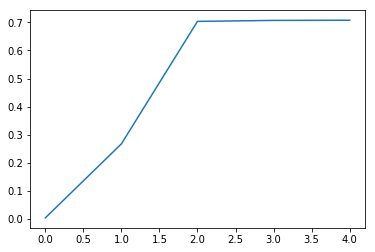

In [152]:
plt.plot(res.history['acc'])

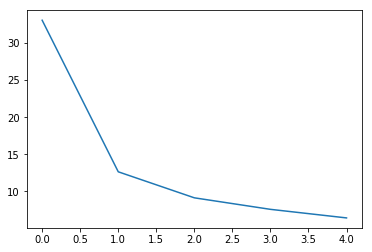

In [153]:
plt.plot(res.history['rmse'])

## CNN - using 'rmsprop' as Optimizer

In [154]:
from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(300))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_72 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_73 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 23, 23, 48)        0         
__________

In [155]:
%time res = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/5
 - 23s - loss: 735.2692 - rmse: 23.9101 - acc: 0.3335 - mean_absolute_error: 20.0053 - val_loss: 257.3682 - val_rmse: 16.0324 - val_acc: 0.6963 - val_mean_absolute_error: 13.1919
Epoch 2/5
 - 23s - loss: 220.8780 - rmse: 14.7327 - acc: 0.7074 - mean_absolute_error: 11.7562 - val_loss: 205.1158 - val_rmse: 14.3152 - val_acc: 0.6963 - val_mean_absolute_error: 12.0087
Epoch 3/5
 - 24s - loss: 189.7487 - rmse: 13.6256 - acc: 0.7074 - mean_absolute_error: 10.9658 - val_loss: 122.5237 - val_rmse: 11.0630 - val_acc: 0.6963 - val_mean_absolute_error: 8.8613
Epoch 4/5
 - 28s - loss: 183.7163 - rmse: 13.3872 - acc: 0.7074 - mean_absolute_error: 10.9187 - val_loss: 204.5469 - val_rmse: 14.2992 - val_acc: 0.6963 - val_mean_absolute_error: 12.2106
Epoch 5/5
 - 23s - loss: 162.8539 - rmse: 12.6210 - acc: 0.7074 - mean_absolute_error: 10.2159 - val_loss: 124.8202 - val_rmse: 11.1704 - val_acc: 0.6963 - val_mean_absolute_error: 9.0711
Wall time:

## CNN - Adam Optimizer; 

In [157]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_17 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_77 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_78 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 23, 23, 48)        0         
__________

In [158]:
%time res = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/5
 - 24s - loss: 989.2047 - rmse: 28.6068 - acc: 0.2103 - mean_absolute_error: 24.2803 - val_loss: 176.3235 - val_rmse: 13.2720 - val_acc: 0.3084 - val_mean_absolute_error: 10.0334
Epoch 2/5
 - 23s - loss: 126.5470 - rmse: 11.1830 - acc: 0.3540 - mean_absolute_error: 8.6261 - val_loss: 84.7751 - val_rmse: 9.1981 - val_acc: 0.6963 - val_mean_absolute_error: 6.8736
Epoch 3/5
 - 24s - loss: 67.9445 - rmse: 8.1779 - acc: 0.7074 - mean_absolute_error: 6.1635 - val_loss: 52.4019 - val_rmse: 7.2269 - val_acc: 0.6963 - val_mean_absolute_error: 5.3600
Epoch 4/5
 - 27s - loss: 43.2026 - rmse: 6.5493 - acc: 0.7074 - mean_absolute_error: 4.8926 - val_loss: 40.3571 - val_rmse: 6.3282 - val_acc: 0.6963 - val_mean_absolute_error: 4.6331
Epoch 5/5
 - 25s - loss: 32.2165 - rmse: 5.6691 - acc: 0.7074 - mean_absolute_error: 4.2109 - val_loss: 35.4036 - val_rmse: 5.9335 - val_acc: 0.6963 - val_mean_absolute_error: 4.3748
Wall time: 2min 4s


## Add Dropout Layer

In [159]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
model.add(Dropout(0.3))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_82 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_83 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 23, 23, 48)        0         
__________

In [161]:
%time res = model.fit(X_train, y_train, epochs=15, batch_size=200, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/15
 - 25s - loss: 188.3176 - rmse: 13.7187 - acc: 0.2973 - mean_absolute_error: 10.6898 - val_loss: 40.6159 - val_rmse: 6.3558 - val_acc: 0.6963 - val_mean_absolute_error: 4.6877
Epoch 2/15
 - 24s - loss: 175.8321 - rmse: 13.2539 - acc: 0.2862 - mean_absolute_error: 10.3627 - val_loss: 40.2040 - val_rmse: 6.3337 - val_acc: 0.6963 - val_mean_absolute_error: 4.6790
Epoch 3/15
 - 24s - loss: 164.2099 - rmse: 12.8122 - acc: 0.2979 - mean_absolute_error: 9.9847 - val_loss: 45.8625 - val_rmse: 6.7689 - val_acc: 0.6963 - val_mean_absolute_error: 5.0499
Epoch 4/15
 - 25s - loss: 157.5233 - rmse: 12.5445 - acc: 0.3201 - mean_absolute_error: 9.7441 - val_loss: 31.0761 - val_rmse: 5.5621 - val_acc: 0.6963 - val_mean_absolute_error: 4.1254
Epoch 5/15
 - 23s - loss: 150.9642 - rmse: 12.2826 - acc: 0.3067 - mean_absolute_error: 9.5862 - val_loss: 33.8873 - val_rmse: 5.8161 - val_acc: 0.6963 - val_mean_absolute_error: 4.3057
Epoch 6/15
 - 25s - l

## Without Dropout Layer

In [162]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(200))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
#model.add(Dropout(0.3))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_87 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_88 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 23, 23, 48)        0         
__________

In [163]:
%time res = model.fit(X_train, y_train, epochs=50, batch_size=200, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 25s - loss: 1725.6577 - rmse: 40.3767 - acc: 0.0000e+00 - mean_absolute_error: 36.2302 - val_loss: 452.1836 - val_rmse: 21.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 16.2170
Epoch 2/50
 - 25s - loss: 271.5662 - rmse: 16.3289 - acc: 0.0403 - mean_absolute_error: 13.0012 - val_loss: 261.0379 - val_rmse: 16.1476 - val_acc: 0.0187 - val_mean_absolute_error: 11.9539
Epoch 3/50
 - 23s - loss: 181.4267 - rmse: 13.3692 - acc: 0.3405 - mean_absolute_error: 10.3641 - val_loss: 114.5201 - val_rmse: 10.6943 - val_acc: 0.6963 - val_mean_absolute_error: 8.1335
Epoch 4/50
 - 24s - loss: 114.1115 - rmse: 10.6730 - acc: 0.7074 - mean_absolute_error: 8.0971 - val_loss: 99.1819 - val_rmse: 9.9535 - val_acc: 0.6963 - val_mean_absolute_error: 7.6700
Epoch 5/50
 - 26s - loss: 86.9223 - rmse: 9.3015 - acc: 0.7074 - mean_absolute_error: 6.9725 - val_loss: 81.6009 - val_rmse: 9.0295 - val_acc: 0.6963 - val_mean_absolute_error: 6.8517
Epoch

 - 24s - loss: 8.9057 - rmse: 2.9811 - acc: 0.7074 - mean_absolute_error: 2.1780 - val_loss: 9.0407 - val_rmse: 3.0046 - val_acc: 0.6963 - val_mean_absolute_error: 2.2262
Epoch 46/50
 - 26s - loss: 8.7279 - rmse: 2.9535 - acc: 0.7074 - mean_absolute_error: 2.1519 - val_loss: 9.1402 - val_rmse: 3.0211 - val_acc: 0.6963 - val_mean_absolute_error: 2.2411
Epoch 47/50
 - 28s - loss: 8.6517 - rmse: 2.9402 - acc: 0.7074 - mean_absolute_error: 2.1391 - val_loss: 8.8126 - val_rmse: 2.9661 - val_acc: 0.6963 - val_mean_absolute_error: 2.1939
Epoch 48/50
 - 24s - loss: 8.6787 - rmse: 2.9448 - acc: 0.7074 - mean_absolute_error: 2.1506 - val_loss: 9.7105 - val_rmse: 3.1133 - val_acc: 0.6963 - val_mean_absolute_error: 2.3162
Epoch 49/50
 - 23s - loss: 8.9367 - rmse: 2.9868 - acc: 0.7074 - mean_absolute_error: 2.1907 - val_loss: 8.8045 - val_rmse: 2.9650 - val_acc: 0.6963 - val_mean_absolute_error: 2.1951
Epoch 50/50
 - 24s - loss: 8.5072 - rmse: 2.9152 - acc: 0.7074 - mean_absolute_error: 2.1244 - va

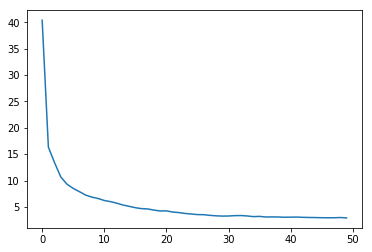

In [164]:
plt.plot(res.history['rmse'])

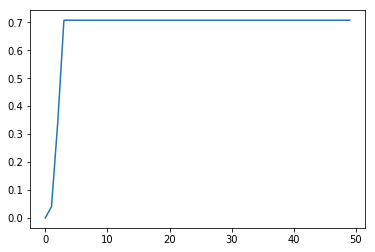

In [165]:
plt.plot(res.history['acc'])